In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

## EDA

In [5]:
# load data
movie_df = pd.read_pickle('movie_df.pickle')
movie_df.head()

,title,year,genre,certificate,runtime,rating,metascore,directors,stars,votes,gross
0,The Shawshank Redemption,1994,Drama,R,142,9.3,81,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2557260,28.34
1,The Dark Knight,2008,"Action, Crime, Drama",R,152,9.1,84,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2515386,534.86
2,Inception,2010,"Action, Adventure, Sci-Fi",R,148,8.8,74,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",2245839,292.58
3,Fight Club,1999,Drama,R,139,8.8,66,David Fincher,"Brad Pitt, Edward Norton, Meat Loaf, Zach Grenier",2013290,37.03
4,Forrest Gump,1994,"Drama, Romance",R,142,8.8,82,Robert Zemeckis,"Tom Hanks, Robin Wright, Gary Sinise, Sally Field",1973564,330.25


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        4000 non-null   object
 1   year         4000 non-null   object
 2   genre        4000 non-null   object
 3   certificate  3794 non-null   object
 4   runtime      4000 non-null   object
 5   rating       4000 non-null   object
 6   metascore    3810 non-null   object
 7   directors    4000 non-null   object
 8   stars        4000 non-null   object
 9   votes        4000 non-null   object
 10  gross        3648 non-null   object
dtypes: object(11)
memory usage: 343.9+ KB


In [7]:
# title - remove rows with duplicate values
movie_df.drop_duplicates('title', inplace = True)

In [8]:
movie_df.shape

(3923, 11)

In [9]:
# any na values?
is_NaN = movie_df.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = movie_df[row_has_NaN]
print(rows_with_NaN)

                                                  title  year  \
325                               It's a Wonderful Life  1946   
439                        Zack Snyder's Justice League  2021   
527                                            Bird Box  2018   
545                                   The Suicide Squad  2021   
552                               To Kill a Mockingbird  1962   
...                                                 ...   ...   
3981                                 Color Out of Space  2019   
3985                            Dragged Across Concrete  2018   
3987  The Guernsey Literary and Potato Peel Pie Society  2018   
3993                                            Shutter  2004   
3997                                           Big Stan  2007   

                           genre certificate runtime rating metascore  \
325       Drama, Family, Fantasy       PG-13     130    8.7        89   
439   Action, Adventure, Fantasy          PG     242    8.1        54   


In [10]:
movie_df['genre'].value_counts().sort_values(ascending=False)

Comedy, Drama, Romance          160
Animation, Adventure, Comedy    136
Action, Adventure, Sci-Fi       128
Comedy                          119
Drama                           114
                               ... 
Animation, Biography, Crime       1
Crime, Fantasy, Horror            1
Drama, Horror, Romance            1
Adventure, Horror                 1
Adventure, Crime, Thriller        1
Name: genre, Length: 331, dtype: int64

In [11]:
movie_df['certificate'].value_counts()

R         1815
PG-13     1023
PG         839
Passed      48
Name: certificate, dtype: int64

In [12]:
# gross - drop rows with missing values
movie_df.dropna(subset = ['gross'], axis = 0, inplace = True)

# certificate - drop rows with missing values & with "Passed"
movie_df.dropna(subset = ['certificate'], axis = 0, inplace = True)
movie_df = movie_df[movie_df['certificate'] != 'Passed']

In [13]:
movie_df['certificate'].value_counts()

R        1676
PG-13     935
PG        770
Name: certificate, dtype: int64

In [14]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3381 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        3381 non-null   object
 1   year         3381 non-null   object
 2   genre        3381 non-null   object
 3   certificate  3381 non-null   object
 4   runtime      3381 non-null   object
 5   rating       3381 non-null   object
 6   metascore    3293 non-null   object
 7   directors    3381 non-null   object
 8   stars        3381 non-null   object
 9   votes        3381 non-null   object
 10  gross        3381 non-null   object
dtypes: object(11)
memory usage: 317.0+ KB


In [15]:
# convert year, runtime, rating, metascore, votes, gross to int
#movie_df.year = movie_df.year.astype('int')
movie_df[['year', 'runtime', 'rating', 'metascore', 'votes', 'gross']] = movie_df[['year', 'runtime', 'rating', 'metascore', 'votes', 'gross']].apply(pd.to_numeric)

In [16]:
# drop metascore feature
#movie_df.drop(columns = ['metascore'], inplace = True)
movie_df.dropna(subset = ['metascore'], axis = 0, inplace = True)

In [17]:
# drop stars feature
movie_df.drop(columns = ['stars'], inplace = True)

In [18]:
# find na values - one final check
is_NaN2 = movie_df.isnull()
row_has_NaN2 = is_NaN2.any(axis = 1)
rows_with_NaN2 = movie_df[row_has_NaN2]
print(rows_with_NaN2)

Empty DataFrame
Columns: [title, year, genre, certificate, runtime, rating, metascore, directors, votes, gross]
Index: []


In [19]:
movie_df.sort_values('year').head()

,title,year,genre,certificate,runtime,rating,metascore,directors,votes,gross
3317,Battleship Potemkin,1925,"Drama, History, Thriller",R,66,8.0,97.0,Sergei Eisenstein,56707,0.05
1224,Metropolis,1927,"Drama, Sci-Fi",R,153,8.3,98.0,Fritz Lang,170407,1.24
3166,All Quiet on the Western Front,1930,"Drama, War",PG,152,8.1,91.0,Lewis Milestone,60412,3.27
1138,City Lights,1931,"Comedy, Drama, Romance",PG,87,8.5,99.0,Charles Chaplin,180317,0.02
2070,It Happened One Night,1934,"Comedy, Romance",PG,105,8.1,87.0,Frank Capra,101379,4.36


In [20]:
movie_df.sort_values('runtime').head()

,title,year,genre,certificate,runtime,rating,metascore,directors,votes,gross
1633,Dumbo,1941,"Animation, Adventure, Drama",R,64,7.3,96.0,"Samuel Armstrong, Norman Ferguson, Wilfred Jac...",128665,1.60
3317,Battleship Potemkin,1925,"Drama, History, Thriller",R,66,8.0,97.0,Sergei Eisenstein,56707,0.05
2392,The Land Before Time,1988,"Animation, Adventure, Drama",PG-13,69,7.4,66.0,Don Bluth,86415,48.09
2249,Following,1998,"Crime, Mystery, Thriller",PG-13,69,7.5,60.0,Christopher Nolan,91757,0.05
1495,Bambi,1942,"Animation, Adventure, Drama",R,70,7.3,91.0,"James Algar, Samuel Armstrong, David Hand, Gra...",139454,102.80


In [21]:
movie_df.sort_values('rating').head()

,title,year,genre,certificate,runtime,rating,metascore,directors,votes,gross
2649,Justin Bieber: Never Say Never,2011,"Documentary, Music",R,105,1.7,52.0,Jon M. Chu,76208,73.01
2289,Disaster Movie,2008,"Comedy, Sci-Fi",PG-13,87,1.9,15.0,"Jason Friedberg, Aaron Seltzer",90556,14.19
3372,Son of the Mask,2005,"Comedy, Family, Fantasy",PG,94,2.2,20.0,Lawrence Guterman,55563,17.02
2000,Epic Movie,2007,"Adventure, Comedy, Fantasy",PG-13,86,2.4,17.0,"Jason Friedberg, Aaron Seltzer",104820,39.74
3910,Alone in the Dark,2005,"Action, Horror, Sci-Fi",PG,96,2.4,9.0,Uwe Boll,45370,5.18


In [22]:
movie_df.sort_values('gross').head(10)

,title,year,genre,certificate,runtime,rating,metascore,directors,votes,gross
3198,Perfect Sense,2011,"Drama, Romance, Sci-Fi",PG,92,7.1,55.0,David Mackenzie,59364,0.00
3664,Adam's Apples,2005,"Comedy, Crime, Drama",PG-13,94,7.7,51.0,Anders Thomas Jensen,49737,0.00
3870,Ginger Snaps,2000,"Drama, Fantasy, Horror",PG,108,6.8,70.0,John Fawcett,46072,0.00
3443,Wild Card,2015,"Action, Crime, Drama",R,92,5.6,40.0,Simon West,54454,0.00
853,Mr. Nobody,2009,"Drama, Fantasy, Romance",R,141,7.8,63.0,Jaco Van Dormael,228701,0.00
3583,The Condemned,2007,"Action, Crime, Thriller",R,113,6.0,23.0,Scott Wiper,51678,0.00
3767,London Boulevard,2010,"Crime, Drama",R,103,6.2,52.0,William Monahan,47814,0.01
1634,All About Eve,1950,Drama,R,138,8.3,98.0,Joseph L. Mankiewicz,128625,0.01
1233,Memories of Murder,2003,"Crime, Drama, Mystery",R,132,8.1,82.0,Bong Joon Ho,169182,0.01
1219,Dial M for Murder,1954,"Crime, Thriller",R,105,8.2,75.0,Alfred Hitchcock,171073,0.01


In [23]:
movie_df.describe()

,year,runtime,rating,metascore,votes,gross
count,3293.000000,3293.000000,3293.000000,3293.000000,3.293000e+03,3293.000000
mean,2002.893410,112.349226,6.831886,59.913756,1.991221e+05,68.107358
std,13.571417,20.414704,0.897718,17.858390,2.289917e+05,82.961881
min,1925.000000,64.000000,1.700000,9.000000,4.400200e+04,0.000000
25%,1998.000000,98.000000,6.300000,47.000000,7.211300e+04,16.290000
50%,2006.000000,109.000000,6.900000,60.000000,1.175590e+05,43.000000
75%,2012.000000,123.000000,7.500000,73.000000,2.322080e+05,87.340000
max,2021.000000,238.000000,9.300000,100.000000,2.557260e+06,936.660000


In [24]:
movie_df.sort_values('rating', inplace=True)

### Visualization

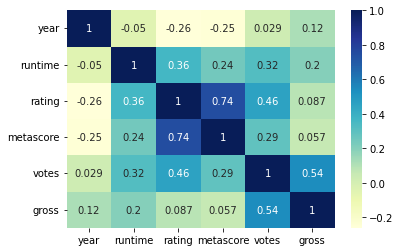

In [25]:
ax = sns.heatmap(movie_df.corr(), cmap = 'YlGnBu', annot = True)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('movie_df_heatmap.png')

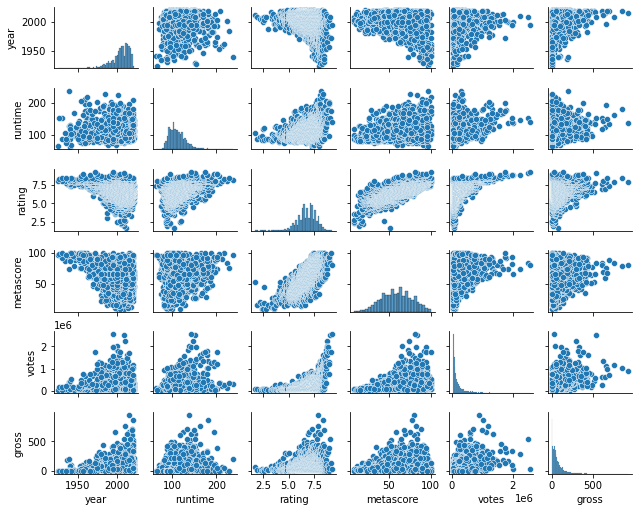

In [26]:
sns.pairplot(movie_df, height=1.2, aspect=1.25)
plt.savefig('movie_df pairplot.png')

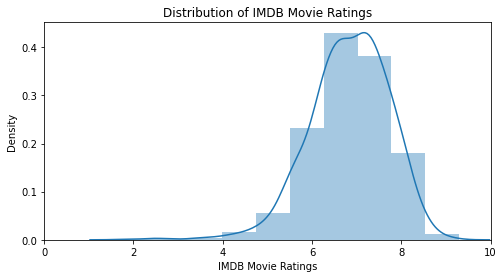

In [27]:
plt.figure(figsize = (8, 4))
ax = sns.distplot(movie_df['rating'], bins = 10, kde_kws = {'bw': 0.25}, 
                  axlabel = 'IMDB Movie Ratings')
ax.set(xlim = (0, 10))
ax.set_title('Distribution of IMDB Movie Ratings')
plt.savefig('Distribution of IMDB Movie Ratings.png')

In [28]:
# get the correlations withh rating
movie_df.corr()['rating'].sort_values(ascending = False)

rating       1.000000
metascore    0.744095
votes        0.455749
runtime      0.361662
gross        0.087322
year        -0.261937
Name: rating, dtype: float64

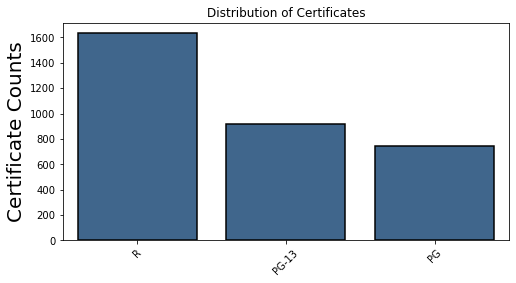

In [29]:
# certificate
plt.subplots(figsize = (8,4))
cert_counts = movie_df['certificate'].value_counts()
cert_counts = cert_counts[:10]
ax = sns.barplot(cert_counts.index, cert_counts.values, color = (0.2, 0.4, 0.6),
                 edgecolor = (0, 0, 0), linewidth = 1.5)
ax.set_ylabel('Certificate Counts', fontsize = 20);
ax.set_title('Distribution of Certificates')
ax.set_xticklabels(cert_counts.index, rotation = 45);

plt.savefig('Cert', bbox_inches = 'tight')

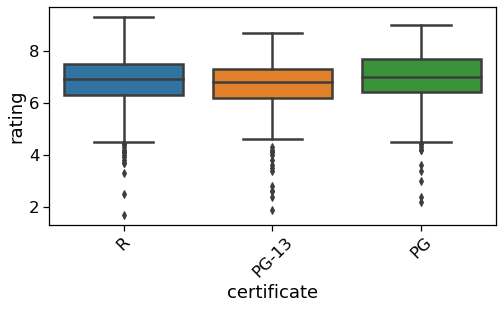

In [30]:
plt.figure(figsize=(8,4))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.boxplot(x="certificate", y="rating", data=movie_df)
plt.xticks(rotation=45);

check for multicollinearity

In [31]:
df_m = movie_df[['year', 'runtime', 'metascore','votes', 'gross']]
vif_data = [variance_inflation_factor(df_m.values, i) for i in range(df_m.shape[1])]
print(pd.Series(vif_data, index = df_m.columns))

year         37.586668
runtime      35.957950
metascore    13.861591
votes         2.850232
gross         2.405998
dtype: float64


In [32]:
df_m2 = movie_df[['runtime', 'metascore', 'votes', 'gross']] #dropping year
vif_data2 = [variance_inflation_factor(df_m2.values, i) for i in range(df_m2.shape[1])]
print(pd.Series(vif_data2, index = df_m2.columns))

runtime      12.242931
metascore    11.843376
votes         2.673908
gross         2.385208
dtype: float64


In [46]:
# make a copy of the movid_df before doing feature engineering
moviedf_copy = movie_df.copy()
moviedf_copy.set_index('title',inplace=True)

### Feature Engineering

yrs since release using the year feature

In [47]:
this_year = 2021
moviedf_copy['yrs_since_release'] = moviedf_copy['year'].apply(lambda x: this_year - x)

In [48]:
moviedf_copy.drop(['year'], inplace=True, axis=1)

In [49]:
moviedf_copy.head()

,genre,certificate,runtime,rating,metascore,directors,votes,gross,yrs_since_release
title,,,,,,,,,
Justin Bieber: Never Say Never,"Documentary, Music",R,105,1.7,52.0,Jon M. Chu,76208,73.01,10
Disaster Movie,"Comedy, Sci-Fi",PG-13,87,1.9,15.0,"Jason Friedberg, Aaron Seltzer",90556,14.19,13
Son of the Mask,"Comedy, Family, Fantasy",PG,94,2.2,20.0,Lawrence Guterman,55563,17.02,16
Epic Movie,"Adventure, Comedy, Fantasy",PG-13,86,2.4,17.0,"Jason Friedberg, Aaron Seltzer",104820,39.74,14
Alone in the Dark,"Action, Horror, Sci-Fi",PG,96,2.4,9.0,Uwe Boll,45370,5.18,16


In [50]:
# create dummy variables for certificate
moviedf_copy = pd.get_dummies(moviedf_copy, columns=['certificate'], drop_first=True)

In [52]:
# create dummy variables for genere
genre_dummies = moviedf_copy['genre'].str.get_dummies(sep=', ')
moviedf_copy = pd.concat([moviedf_copy, genre_dummies], axis = 1)

In [53]:
# create dummy variables for directors 
dir_20 = moviedf_copy['directors'].value_counts()[:20].index.tolist()
director_dummies = pd.get_dummies(moviedf_copy['directors'], drop_first=True)
moviedf_copy = pd.concat([moviedf_copy, director_dummies[dir_20]], axis=1)

In [54]:
moviedf_copy.columns

Index(['genre', 'runtime', 'rating', 'metascore', 'directors', 'votes',
       'gross', 'yrs_since_release', 'certificate_PG-13', 'certificate_R',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'Western', 'Steven Spielberg',
       'Clint Eastwood', 'Martin Scorsese', 'Ron Howard', 'Ridley Scott',
       'Woody Allen', 'Tim Burton', 'Robert Zemeckis', 'Tony Scott',
       'Alfred Hitchcock', 'Oliver Stone', 'Michael Bay', 'Steven Soderbergh',
       'Richard Donner', 'John Carpenter', 'M. Night Shyamalan', 'Sam Raimi',
       'Joel Schumacher', 'Christopher Nolan', 'Shawn Levy'],
      dtype='object')

In [55]:
# drop genre and directors columns 
moviedf_copy.drop(['genre', 'directors'], inplace = True, axis = 1)

In [63]:
moviedf_copy.columns

Index(['runtime', 'rating', 'votes', 'gross', 'yrs_since_release',
       'certificate_PG-13', 'certificate_R', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western', 'Steven Spielberg', 'Clint Eastwood',
       'Martin Scorsese', 'Ron Howard', 'Ridley Scott', 'Woody Allen',
       'Tim Burton', 'Robert Zemeckis', 'Tony Scott', 'Alfred Hitchcock',
       'Oliver Stone', 'Michael Bay', 'Steven Soderbergh', 'Richard Donner',
       'John Carpenter', 'M. Night Shyamalan', 'Sam Raimi', 'Joel Schumacher',
       'Christopher Nolan', 'Shawn Levy'],
      dtype='object')

In [61]:
# drop metascore - it is another rating which won't help the model
moviedf_copy.drop(['metascore'], inplace = True, axis = 1)

In [62]:
# quick correlation check
moviedf_copy.corr()['rating'].sort_values(ascending = False)[:30]

rating               1.000000
votes                0.455749
runtime              0.361662
Drama                0.356290
yrs_since_release    0.261937
Biography            0.171365
War                  0.108128
History              0.103403
Christopher Nolan    0.088242
gross                0.087322
Animation            0.078721
Martin Scorsese      0.076359
Alfred Hitchcock     0.075677
Steven Spielberg     0.071142
Film-Noir            0.066833
Western              0.060816
Documentary          0.059383
Musical              0.045455
Clint Eastwood       0.044432
Crime                0.044144
Robert Zemeckis      0.038875
Woody Allen          0.029543
Music                0.028433
Ridley Scott         0.024542
Sport                0.024076
certificate_R        0.020478
News                 0.018798
Tim Burton           0.016325
Sam Raimi            0.010257
Oliver Stone         0.009094
Name: rating, dtype: float64

In [64]:
moviedf_copy.to_csv('movie_dfr.csv', header = True, index = False)